## Gesture Recognition

#### Objective: 
To develop a cool feature in the smart-tv that can recognise five different gestures performed by the user which will help users control the TV without using a remote. We will be using deep learning models to achieve this gesture recognition

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

- The data set contains the following data :

    * Thumbs up: Increase the volume
    * Thumbs down: Decrease the volume
    * Left swipe: 'Jump' backwards 10 seconds
    * Right swipe: 'Jump' forward 10 seconds
    * Stop: Pause the movie


In [1]:
import numpy as np
import os
from imageio import imread
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from keras import backend as K

### Method to get data with ablation. If ablation=None then full data is returned

In [3]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [4]:
train_doc, val_doc = get_data('/home/datasets/Project_data/', ablation=None)
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

In [5]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):
    # print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = np.array(Image.fromarray((image * 1).astype(np.uint8)).convert('RGB').resize([z, y]))
 
                    #imresize(image, size=(y,z))

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
                

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train' 
val_path =  '/home/datasets/Project_data/val' 

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


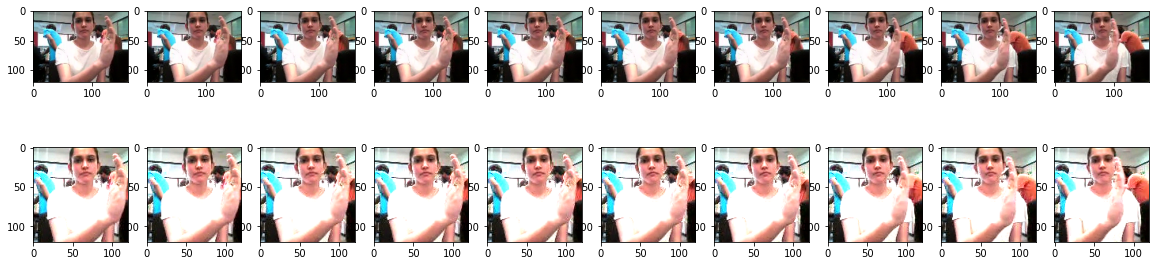

In [7]:
# testing generative 
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[0]

### Util functions

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [9]:
def calculateHistory(model,modelName):
  optimiser = tf.keras.optimizers.Adam(lr=0.01) #write your optimizer
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  print(model.summary())  

  train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
  val_generator = generator(val_path, val_doc, batch_size)
  model_name = 'model_' + modelName + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

  if not os.path.exists(model_name):
    os.mkdir(model_name)

  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', periods=1)

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

  callbacks_list = [checkpoint, LR] 

  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1
  
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
  
  return history

In [10]:
def plotHistory(history):
  plt.figure(figsize=(20,6))
  ax1 = plt.subplot(121)
  ax1 = plt.plot(history.history['loss'])
  ax1 = plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower left')
  ax2 = plt.subplot(122)
  ax2 = plt.plot(history.history['categorical_accuracy'])
  ax2 = plt.plot(history.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('categorical_accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower left') 

### Start with base model with initial batch size set to 128 and then changed to 32

2022-07-12 08:55:38.610484: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-12 08:55:38.610548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 59, 59, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               1

2022-07-12 08:55:41.505558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 10.3044 - categorical_accuracy: 0.1964
Epoch 00001: saving model to model_Conv3D_1_2_2022-07-1208_55_28.887478/model-00001-10.30435-0.19643-1.26065-0.12500.h5
21/21 [==============================] - 32s 1s/step - loss: 10.3044 - categorical_accuracy: 0.1964 - val_loss: 1.2606 - val_categorical_accuracy: 0.1250 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.5915 - categorical_accuracy: 0.1979
Epoch 00002: saving model to model_Conv3D_1_2_2022-07-1208_55_28.887478/model-00002-1.59153-0.19792-1.25743-0.19531.h5
21/21 [==============================] - 29s 1s/step - loss: 1.5915 - categorical_accuracy: 0.1979 - val_loss: 1.2574 - val_categorical_accuracy: 0.1953 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.5885 - categorical_accuracy: 0.1949
Epoch 00003: saving model to model_Conv3D_1_2_2022-07-1208_55_28.887478/model-00003-1.58851-0.19494-1.25409-0.17969.h5
2

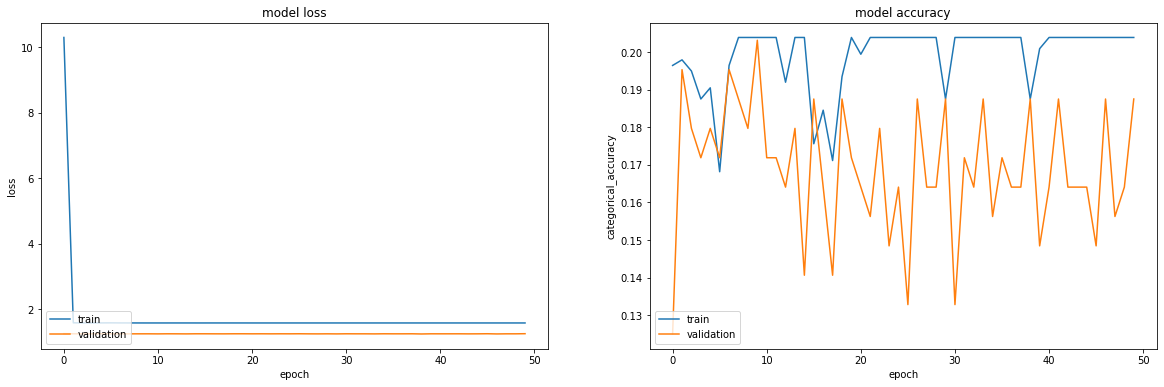

In [12]:
#Experiment 1 & 2 CONV3D
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

history = calculateHistory(model,"Conv3D_1_2")
plotHistory(history)

#### Observation
Reducing the batch size had no impact and no improvement seen in the model.

Next: adding more layers to increase the learning

In [13]:
#Experiment 3 CONV3D
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 2, 2)))

model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

history = calculateHistory(model,"Conv3D_3")
plotHistory(history)

ValueError: Exception encountered when calling layer "max_pooling3d_3" (type MaxPooling3D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling3d_3/MaxPool3D}} = MaxPool3D[T=DT_FLOAT, data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1]](Placeholder)' with input shapes: [?,1,56,56,128].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 56, 56, 128), dtype=float32)

#### Observation:
Error due to kernel size mismatch with the output of previous layers

Next: Reduce the kernel size of new layers 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_6 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 1, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 1, 28, 28, 128)   0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 1, 26, 26, 256)   

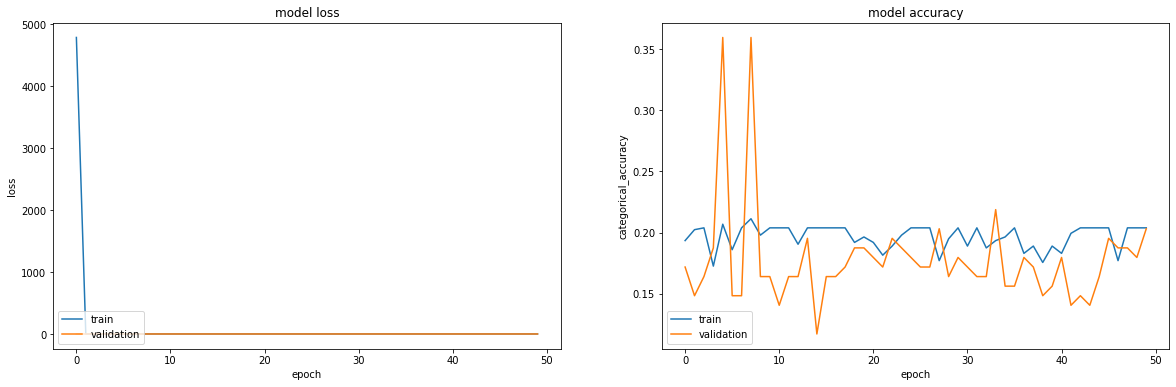

In [14]:
#Experiment 4 CONV3D

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

history = calculateHistory(model,"Conv3D_4")
plotHistory(history)

#### Observation:
No improvement as compared to model2

Next: Add Batch normalization layer after every CNN and dense layers
Model 5 - Test with Ablation data set (less data)
Model 6 - Test with full data set

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_12 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 3, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 3, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 conv3d_13 (Conv3D)          (None, 1, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 1, 28, 28, 128)  

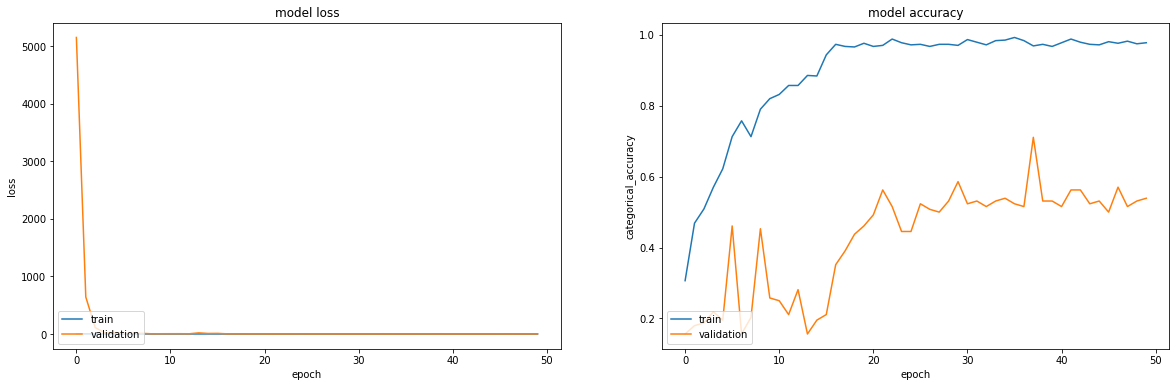

In [15]:
#Experiment 5 & 6 CONV3D

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

history = calculateHistory(model,"Conv3D_5_6")
plotHistory(history)

#### Observation:
Model is still over-fitting.

Next: Add dropouts to generalize the model


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_17 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_18 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 3, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 3, 58, 58, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_19 (Conv3D)          (None, 1, 56, 56, 128)   

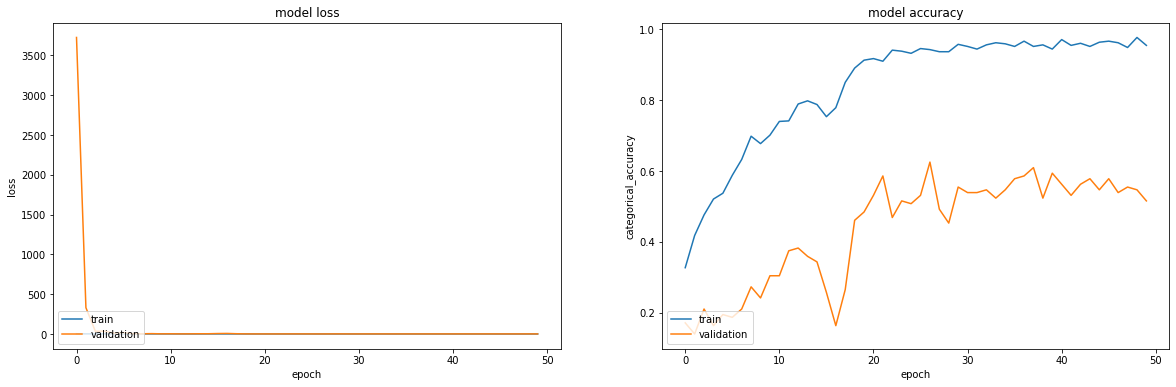

In [16]:
#Experiment 7 & 8 CONV3D

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

history = calculateHistory(model,"Conv3D_7_8")
plotHistory(history)

#### Observation:
Validation accuracy dropped and model is over-fitted.

Next: revert to dropout of 0.2 and reduce a CNN layer to reduce the complexity 

In [12]:
#Experiment 9
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

history = calculateHistory(model,"Conv3D_9")


2022-07-12 11:04:05.431658: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-12 11:04:05.431724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 3, 58, 58, 64)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 56, 56, 128)    2

2022-07-12 11:04:08.874479: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 2.7602 - categorical_accuracy: 0.3646
Epoch 00001: saving model to model_Conv3D_9_2022-07-1211_03_39.605494/model-00001-2.76024-0.36458-2324.11133-0.17969.h5
21/21 [==============================] - 36s 2s/step - loss: 2.7602 - categorical_accuracy: 0.3646 - val_loss: 2324.1113 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.1159 - categorical_accuracy: 0.6176
Epoch 00002: saving model to model_Conv3D_9_2022-07-1211_03_39.605494/model-00002-1.11590-0.61756-257.86359-0.19531.h5
21/21 [==============================] - 29s 1s/step - loss: 1.1159 - categorical_accuracy: 0.6176 - val_loss: 257.8636 - val_categorical_accuracy: 0.1953 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.7915 - categorical_accuracy: 0.7113
Epoch 00003: saving model to model_Conv3D_9_2022-07-1211_03_39.605494/model-00003-0.79152-0.71131-101.54128-0.14844.h

NameError: name 'plotHistory' is not defined

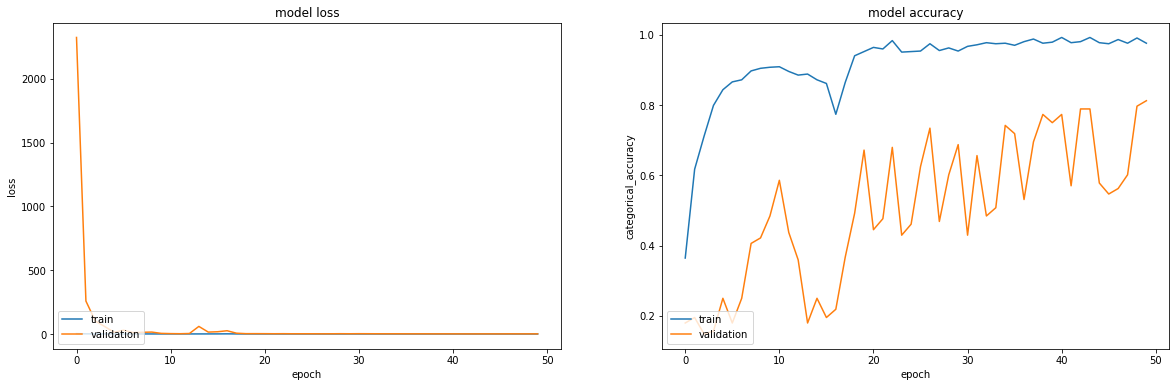

In [14]:
plotHistory(history)

#### Observation:
Model is good

Next: use Global Average Pooling instead of Flatten layer to see if it can be any better


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_5 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 3, 58, 58, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_6 (Conv3D)           (None, 1, 56, 56, 128)   

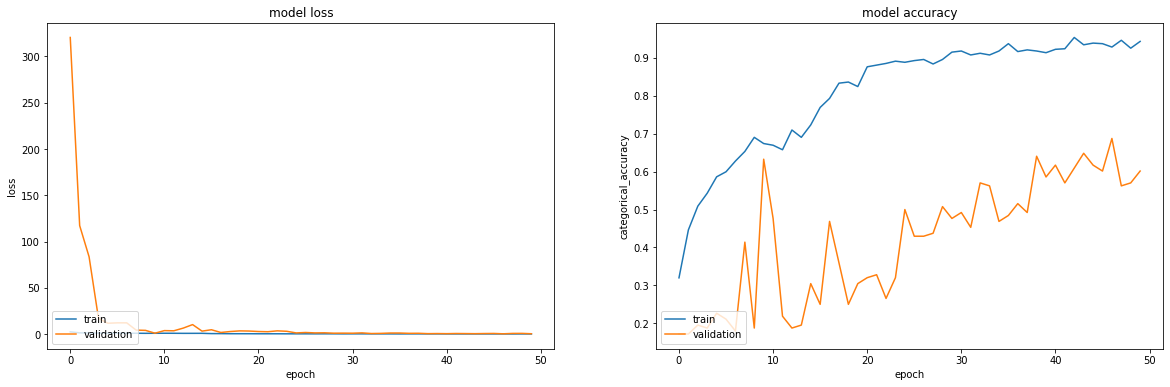

In [15]:
#Experiment 10
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

history = calculateHistory(model,"Conv3D_10")
plotHistory(history)

#### Observation:
Model is over-fitting.

Next: Model 9 has good score. Let us experiment with other architectures.


2022-07-12 13:52:25.227759: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-12 13:52:25.227825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 10, 59, 59, 32)   128       
 ormalization)                                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 28, 28, 64)   0

2022-07-12 13:52:29.904077: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.5753 - categorical_accuracy: 0.3780
Epoch 00001: saving model to model_TimeDistributed_Conv2D_GRU_11_2022-07-1213_51_55.324356/model-00001-1.57529-0.37798-2.52163-0.17969.h5
21/21 [==============================] - 33s 1s/step - loss: 1.5753 - categorical_accuracy: 0.3780 - val_loss: 2.5216 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.1753 - categorical_accuracy: 0.4598
Epoch 00002: saving model to model_TimeDistributed_Conv2D_GRU_11_2022-07-1213_51_55.324356/model-00002-1.17527-0.45982-2.16860-0.19531.h5
21/21 [==============================] - 29s 1s/step - loss: 1.1753 - categorical_accuracy: 0.4598 - val_loss: 2.1686 - val_categorical_accuracy: 0.1953 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.9818 - categorical_accuracy: 0.5699
Epoch 00003: saving model to model_TimeDistributed_Conv2D_GRU_11_2022-07-1213_51_55.3

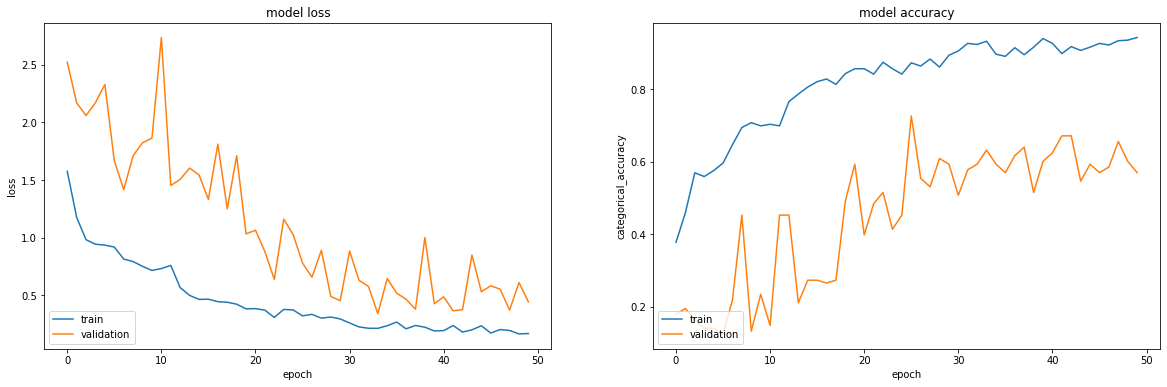

In [11]:
#Experiment 11
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

history = calculateHistory(model,"TimeDistributed_Conv2D_GRU_11")
plotHistory(history)

#### Observation:
Model is over-fitted.

Next: Add dropouts after each layer to reduce over-fitting.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 10, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_12 (Bat  (None, 10, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 10, 59, 59, 32)    0         
                                                                 
 time_distributed_8 (TimeDis  (None, 10, 57, 57, 64)   18496     
 tributed)                                            

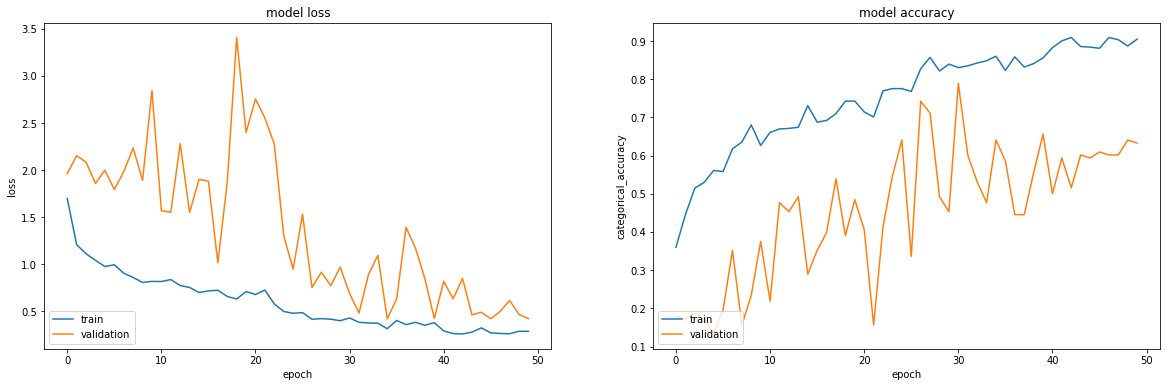

In [17]:
#Experiment 12
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

history = calculateHistory(model,"TimeDistributed_Conv2D_GRU_12")
plotHistory(history)

#### Observation:
Model is still over-fitting.

Next: Replace GRU with plain Dense layer and add global average pooling.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 10, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 10, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_16 (Bat  (None, 10, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_14 (TimeDi  (None, 10, 57, 57, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 10, 28, 28, 64)  

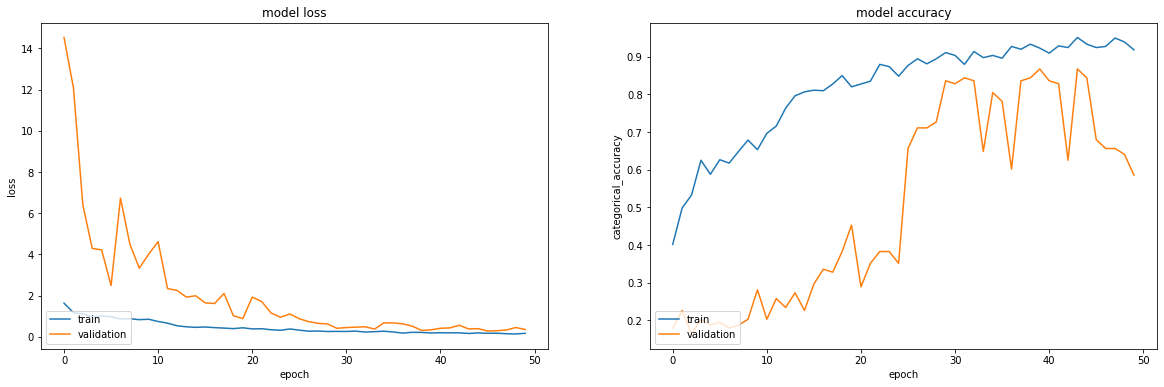

In [18]:
#Experiment 13

model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(128, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

history = calculateHistory(model,"TimeDistributed_Conv2D_DENSE_13")
plotHistory(history)

#### Observation:
Model is still over-fitting. 

Next: Let us try using a different architecture i.e. time distributed with convLSTM2D



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 10, 118, 118, 8)  224       
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 10, 118, 118, 8)  32        
 hNormalization)                                                 
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 10, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)      

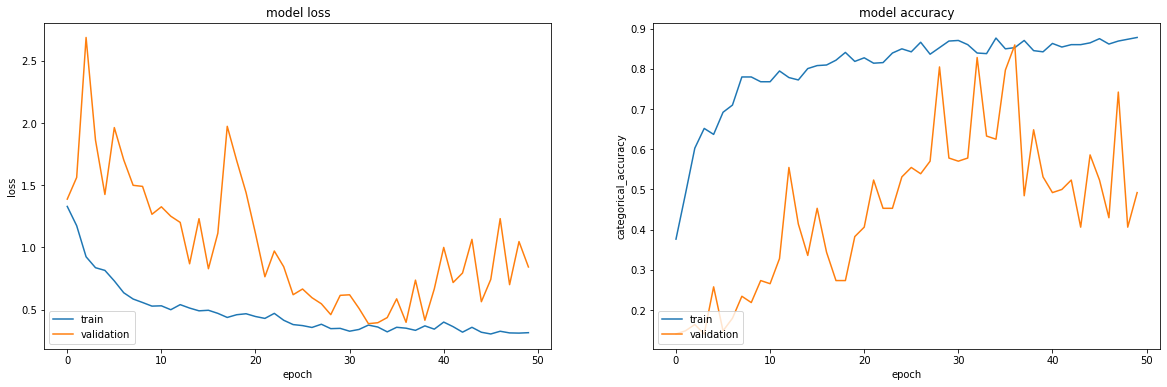

In [12]:
#Experiment 14

model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

history = calculateHistory(model,"TimeDistributed_ConvLSTM2D_14")
plotHistory(history)

#### Observation:
The 37th epoch has generated this value and looks like a good model. 

Now Model 9 has better accuracy than model 14 however model 9 has 22,732,549 parameters but model 14 has only 13,781 parameters and hence chosen as final model.


#### Conclusion : 

Model 14 (Final model) has good accuracy scores and less parameters compared to other models. Even though model 9 has a better accuracy scores there are considerably more parameters and hence Model 14 is chosen as the final model.